<a href="https://colab.research.google.com/github/abazabaaa/colab_tutorial/blob/main/pandas_mol2grd_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
import condacolab
condacolab.check()
!mamba install -c conda-forge rdkit
!mamba install -c pyarrow
!pip install mols2grid
!wget https://raw.githubusercontent.com/abazabaaa/colab_tutorial/main/dopamine_3.csv

In [2]:
import pyarrow as pa
from pyarrow import csv
import pandas as pd
import pyarrow.feather as feather
from rdkit.Chem import PandasTools
import mols2grid
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs


The first action we will take is to ingest the CHEMBL csv which is used to store compound information associated with the dopamine 3 receptor. We will use pyarrow to do this -- it will become apparent later why we are employing this library, as it has some rather useful tools that will help us deal with very large CSV files.

In [3]:
# We select the file we are interested in (we used wget to download this from
# github)

filename = '/content/dopamine_3.csv'

# Next we will the multithreaded read options that pyarrow allows for.

opts = pa.csv.ReadOptions(use_threads=True)

# Then we tell pyarrow that the columns in our csv file are seperated by ';'
# If they were tab seperated we would use '\t' and if it was comma we would use 
# ','
parse_options= pa.csv.ParseOptions(delimiter=';')

# Now we read the CSV into a pyarrow table. This is a columular dataset. More
# on this later. Note how we specified the options above.

table = pa.csv.read_csv(filename, opts, parse_options)







In [4]:
# Now we will use a function that converts the pyarrow table into a pandas 
# dataframe. We could have done this without arrow, but again -- there are 
# very powerful tools that arrow will grant us.

df_new = table.to_pandas()

In [5]:
# A dataframe is like an excel spreadsheet. You can view the table by running 
# the cell below. Note that it will be truncated.

df_new

Molecule ChEMBL ID Molecule Name  ...  Cell ChEMBL ID  Properties
0          CHEMBL298875                ...   CHEMBL3308072            
1         CHEMBL3664844                ...            None            
2         CHEMBL3642730                ...            None            
3         CHEMBL3323013                ...   CHEMBL3307715            
4         CHEMBL4476784                ...   CHEMBL3307715            
...                 ...           ...  ...             ...         ...
5967      CHEMBL4517102                ...   CHEMBL3307715            
5968      CHEMBL4072282                ...            None            
5969      CHEMBL4536530                ...   CHEMBL3308072            
5970      CHEMBL4466114                ...   CHEMBL3308072            
5971      CHEMBL4434714                ...   CHEMBL3308072            

[5972 rows x 45 columns]

In [6]:
# We generally don't want to view the whole dataframe -- sometimes we just need
# to make sure it is formated properly for later tasks. You can use the syntax
# below to enable you to only see the first 5 rows.

df_new.head(5)

Molecule ChEMBL ID Molecule Name  ...  Cell ChEMBL ID  Properties
0       CHEMBL298875                ...   CHEMBL3308072            
1      CHEMBL3664844                ...            None            
2      CHEMBL3642730                ...            None            
3      CHEMBL3323013                ...   CHEMBL3307715            
4      CHEMBL4476784                ...   CHEMBL3307715            

[5 rows x 45 columns]

In [7]:
# Lets say we don't want all the columns and we need to remove some. Lets
# get a list of the column names so we can select some to be removed. We will
# cast the column names to a list with the syntax below.

list(df_new.columns)

['Molecule ChEMBL ID',
 'Molecule Name',
 'Molecule Max Phase',
 'Molecular Weight',
 '#RO5 Violations',
 'AlogP',
 'Compound Key',
 'Smiles',
 'Standard Type',
 'Standard Relation',
 'Standard Value',
 'Standard Units',
 'pChEMBL Value',
 'Data Validity Comment',
 'Comment',
 'Uo Units',
 'Ligand Efficiency BEI',
 'Ligand Efficiency LE',
 'Ligand Efficiency LLE',
 'Ligand Efficiency SEI',
 'Potential Duplicate',
 'Assay ChEMBL ID',
 'Assay Description',
 'Assay Type',
 'BAO Format ID',
 'BAO Label',
 'Assay Organism',
 'Assay Tissue ChEMBL ID',
 'Assay Tissue Name',
 'Assay Cell Type',
 'Assay Subcellular Fraction',
 'Assay Parameters',
 'Assay Variant Accession',
 'Assay Variant Mutation',
 'Target ChEMBL ID',
 'Target Name',
 'Target Organism',
 'Target Type',
 'Document ChEMBL ID',
 'Source ID',
 'Source Description',
 'Document Journal',
 'Document Year',
 'Cell ChEMBL ID',
 'Properties']

In [8]:
# Standard type, relation, value and units are all related to a compounds affinity.
# Lets combine these into one column. You may notive that some columns are blank.
# These are called NaNs, or NoneType entries. Additionally, some of the columns
# may be of different types -- strings, float, integers, etc.
# These can cause headaches for various downstream processes, so lets use some 
# tricks to handle these

df_new['ki'] = df_new[['Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units']].astype(str).agg('-'.join, axis=1)

In [9]:
# Check to see if the new column is at the end. 
df_new.head(2)

Molecule ChEMBL ID Molecule Name  ...  Properties              ki
0       CHEMBL298875                ...              Ki-'='-84.0-nM
1      CHEMBL3664844                ...              Ki-'='-7.15-nM

[2 rows x 46 columns]

In [10]:
# Ok. Now lets clean up the dataframe and only keep columns that are of interest
# to us.

df_clean = df_new[['Molecule ChEMBL ID', 'ki', 'Smiles', 'Document Journal', 'Document Year']]

In [11]:
df_clean.head(1)

Molecule ChEMBL ID              ki  ...          Document Journal Document Year
0       CHEMBL298875  Ki-'='-84.0-nM  ...  Bioorg. Med. Chem. Lett.          2003

[1 rows x 5 columns]

/usr/local/lib/python3.7/site-packages/rdkit/Chem/PandasTools.py:425: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


Molecule ChEMBL ID  ...                                              ROMol
0       CHEMBL298875  ...  <img data-content="rdkit/molecule" src="data:i...
1      CHEMBL3664844  ...  <img data-content="rdkit/molecule" src="data:i...

[2 rows x 6 columns]
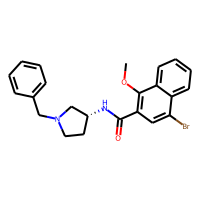
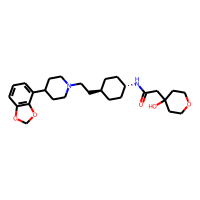

In [12]:
# Lets add a column that allows us to see the structures.
PandasTools.AddMoleculeColumnToFrame(df_clean, smilesCol='Smiles')
df_clean.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Molecule ChEMBL ID  ... Tanimoto_Similarity (ECFP4)
417          CHEMBL8946  ...                    0.700000
4947         CHEMBL8946  ...                    0.700000
3821         CHEMBL8946  ...                    0.700000
236          CHEMBL8809  ...                    0.587302
5926         CHEMBL8809  ...                    0.587302
...                 ...  ...                         ...
3328       CHEMBL287198  ...                    0.267442
3044       CHEMBL169229  ...                    0.264368
1229       CHEMBL285816  ...                    0.261905
3228      CHEMBL3597642  ...                    0.261364
2815      CHEMBL3597641  ...                    0.261364

[100 rows x 7 columns]
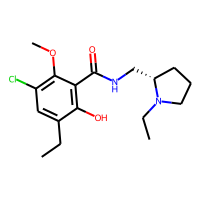
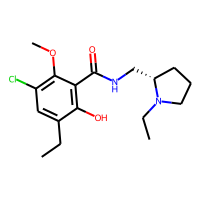
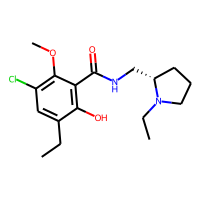
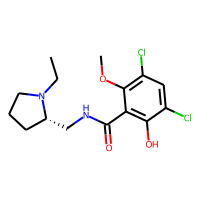
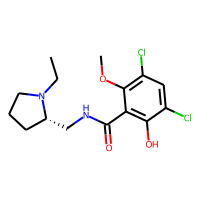
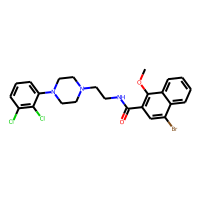
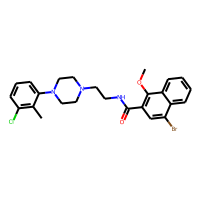
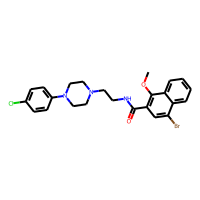
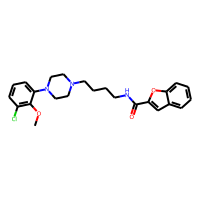
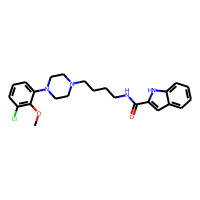

In [13]:
# OK. Lets get sophisticated and say we want to compare a molecule we have
# to an existing d3 ligand. 

ref_smiles = 'CCC1=CC(Cl)=C(OC)C(C(NC[C@H]2C[C@H](OC)CN2CC)=O)=C1O'
ref_mol = Chem.MolFromSmiles(ref_smiles)

# Now, lets take a look how similar our molecule is to existing structures.

ref_ECFP4_fps = AllChem.GetMorganFingerprintAsBitVect(ref_mol,2)
bulk_ECFP4_fps = [AllChem.GetMorganFingerprintAsBitVect(x,2) for x in df_clean['ROMol']]
similarity_efcp4 = [DataStructs.FingerprintSimilarity(ref_ECFP4_fps,x) for x in bulk_ECFP4_fps]
df_clean['Tanimoto_Similarity (ECFP4)'] = similarity_efcp4

final_df = df_clean.sort_values(by=['Tanimoto_Similarity (ECFP4)'], ascending=False)
final_df.head(100)

In [14]:
df = final_df.head(400)


In [15]:
mg = mols2grid.MolGrid(df, smiles_col="Smiles", size=(220, 180))
mg.display(subset=["Molecule ChEMBL ID", 'Tanimoto_Similarity (ECFP4)', 'ki', "img"], n_cols=7)